In [2]:
import os
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable

In [ ]:
import pickle

pkl_file = open('mjd_dict.pickle', 'rb')
mjds = pickle.load(pkl_file)


In [150]:
def source_distance(src1, src2):
    ra, dec = src1['ra'], src1['dec']
    ra2, dec2 = src2['ra'], src2['dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600


def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves


In [4]:
files = os.listdir("vc_catalogs")

multi_matches = None

for f in files:
    
    catalog = afwTable.SourceCatalog.readFits("vc_catalogs/"+f)
    
    if multi_matches is None:
        multi_matches = afwTable.MultiMatch(catalog[0].schema, {'visit':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
    multi_matches.add(catalog, {'visit':int(f.split(".")[0])})
    
results = multi_matches.finish(removeAmbiguous=False)

In [192]:
light_curves = []
i = 0
current = -1
while i < len(results):
    result = results[i]
    if current == -1 or current != result['object']:
        lc = [(result['visit'],result)]
        light_curves.append(lc)
        current = result['object']
    else:
        light_curves[-1].append((result['visit'],result))
    i+=1

t_light_curves = threshold_light_curves(light_curves, 10)

In [146]:
def build_light_curve_from_snls_file(data, c):

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for mjd, flux, error in data:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(float(mjd))
        lightcurve['ra'].append(c.ra.radian)
        lightcurve['dec'].append(c.dec.radian)
        lightcurve['flux'].append(float(flux))
        lightcurve['flux_error'].append(float(error))
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')

    lc = Table(data=lightcurve)
    return lc


In [161]:
from astropy.table import Table
def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(mjds[str(visit)])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_CircularApertureFlux_4_5_flux'])
        lightcurve['flux_error'].append(src['base_CircularApertureFlux_4_5_fluxSigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve


In [136]:
def mean_lc_flux(lc2):
    import numpy as np
    mjds = []
    m_fluxes = []
    m_error = []
    s_error = []
    i = 0
    while i < len(lc2['mjd']):
        mjd = lc2['mjd'][i]
        j = i+1
        mjds.append(int(mjd))
        m_fluxes.append(lc2['flux'][i]*lc2['flux_error'][i])
        m_error.append(lc2['flux_error'][i])
        s_error.append(lc2['flux_error'][i]**2)
        total = 1.
       
        while j<len(lc2['mjd']) and int(lc2['mjd'][j]) == int(mjd):

            m_fluxes[-1]+= lc2['flux'][j]*lc2['flux_error'][j]
            

                
            m_error[-1] += lc2['flux_error'][j]
            s_error[-1] += (lc2['flux_error'][j]**2)
            #mjds[-1] += int(lc2['mjd'][j])
            total+=1
            j+=1
            
       
        m_fluxes[-1] = np.divide(m_fluxes[-1], m_error[-1] )
        m_error[-1] = np.divide(np.sqrt(s_error[-1]), total)
        i = j

    return mjds, m_fluxes, m_error


In [193]:
print len(t_light_curves)

1084


In [194]:
#lc = build_lightcurve(t_light_curves[4])
lcs = []
for t_light_curve in t_light_curves:
    lcs.append(build_lightcurve(t_light_curve))

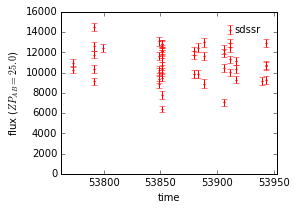

In [195]:
import sncosmo
%matplotlib inline
sncosmo.plot_lc(lcs[7], color="red")
plt.show()

In [198]:
lc = lcs[7]
time, m_fluxes, m_error = mean_lc_flux(lc)

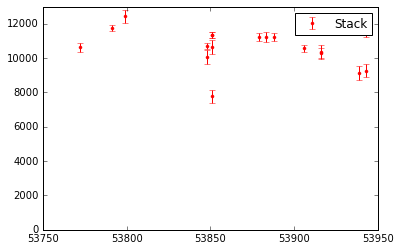

In [199]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.errorbar(time, m_fluxes, yerr=m_error, fmt='.', color='red', label='Stack')
plt.legend(numpoints=1)
plt.ylim(ymin=0)
plt.show()

In [91]:
print time, m_fluxes

[53769, 53772, 53791, 53799, 53848, 53851, 53875, 53879, 53883, 53888, 53892, 53906, 53911, 53916, 53919, 53935, 53939, 53943] [7669.7662971923692, 8110.7611821770242, 7437.9243611358288, 9049.1229587427351, 6535.0479515193629, 6231.6378478519246, 4329.9609413955795, 6119.8024119199081, 5652.0594649351806, 6437.9838834791817, 7092.713854312492, 5097.7957621737642, 5134.4969595664943, 4917.2141833839796, 5193.7302508008515, 23.914294711042963, 4689.7033063331037, 3925.0598810451329]


06D3bz


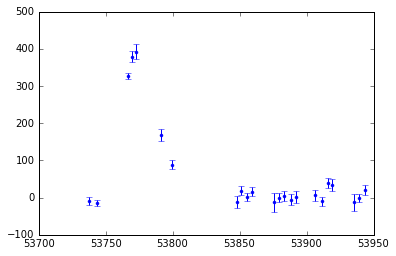

06D3cb


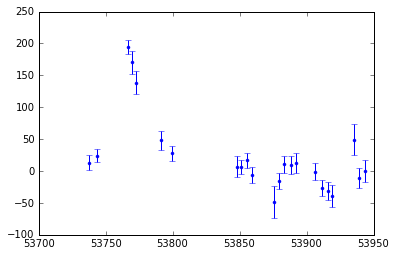

06D3cc


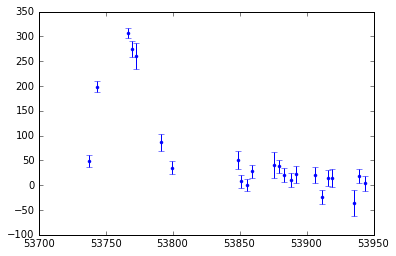

06D3cn


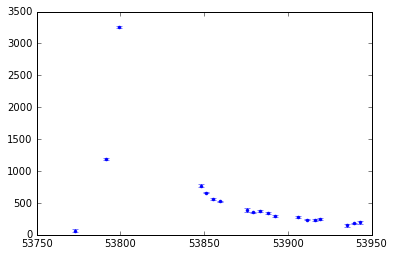

06D3df


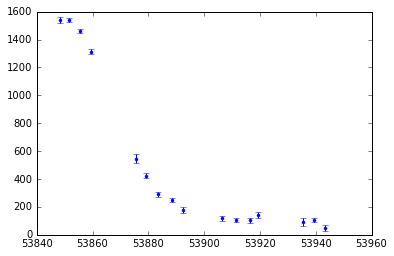

06D3dl


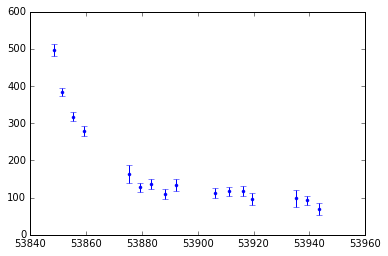

06D3do


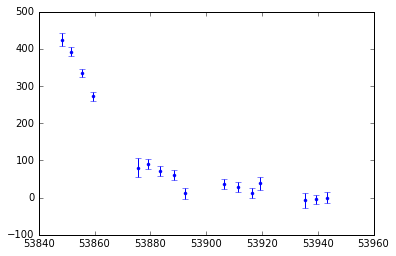

06D3dt


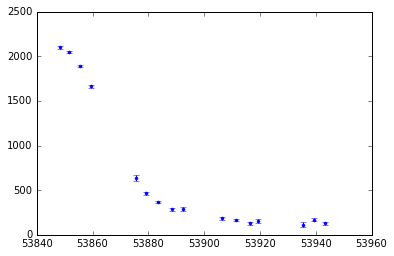

06D3ed


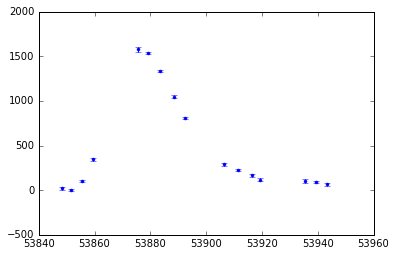

06D3el


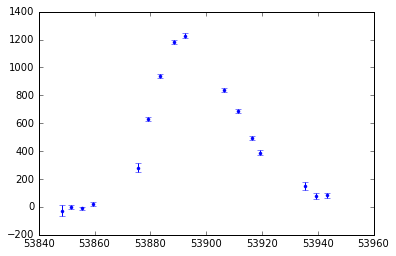

06D3em


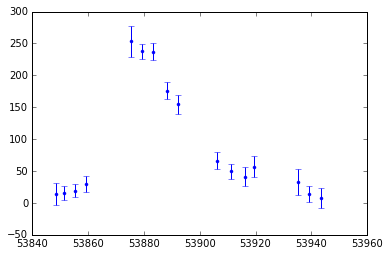

06D3en


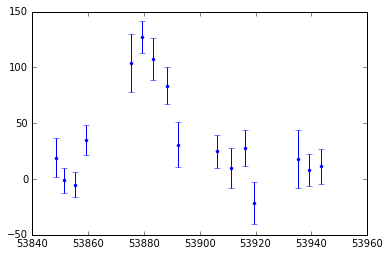

06D3et


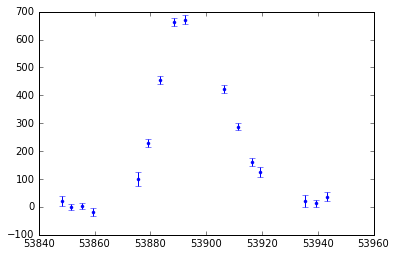

06D3fp


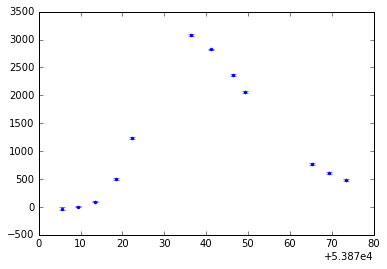

06D3gh


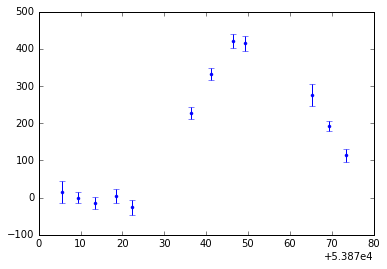

06D3gn


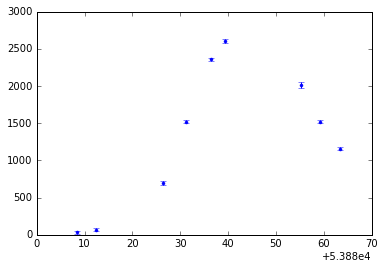

06D3gx


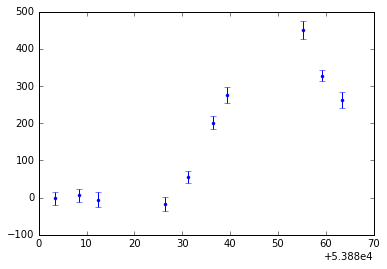

In [148]:
import re
import astropy.coordinates as coord
import astropy.units as u

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#m = re.findall('^06D3.*?\\|(.*?)\\|', data, re.MULTILINE)
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

import matplotlib.pyplot as plt
%matplotlib inline
snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    print sn[0]
    snls_lc = build_light_curve_from_snls_file(m, c)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    snls_array.append(snls_lc)
    plt.show()
    
#pickle.dump(snls_array, open('/renoir_data_02/jpreyes/lsst_data/transients_files/snls_transients_filter_r.lc', 'wb'))


In [170]:
matches = []
for sn in elems:
    
    match = False
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    
    for i, lc in enumerate(lcs):
        #print lc[0]['ra']
        #print lc[0]['dec']
        if source_distance(lc[0], {'ra':c.ra.radian, 'dec':c.dec.radian}) < 2:
            match = True
 
            matches.append((sn[0], i))
            break
    
        #print 'no match'
print 'found ' + str(float(len(matches))/float(len(elems))) 

found 0.470588235294


In [177]:
frequencies = {}

for lc in lcs:
    if frequencies.has_key(len(lc)):
        frequencies[len(lc)] += 1
    else:
        frequencies[len(lc)] = 1
    


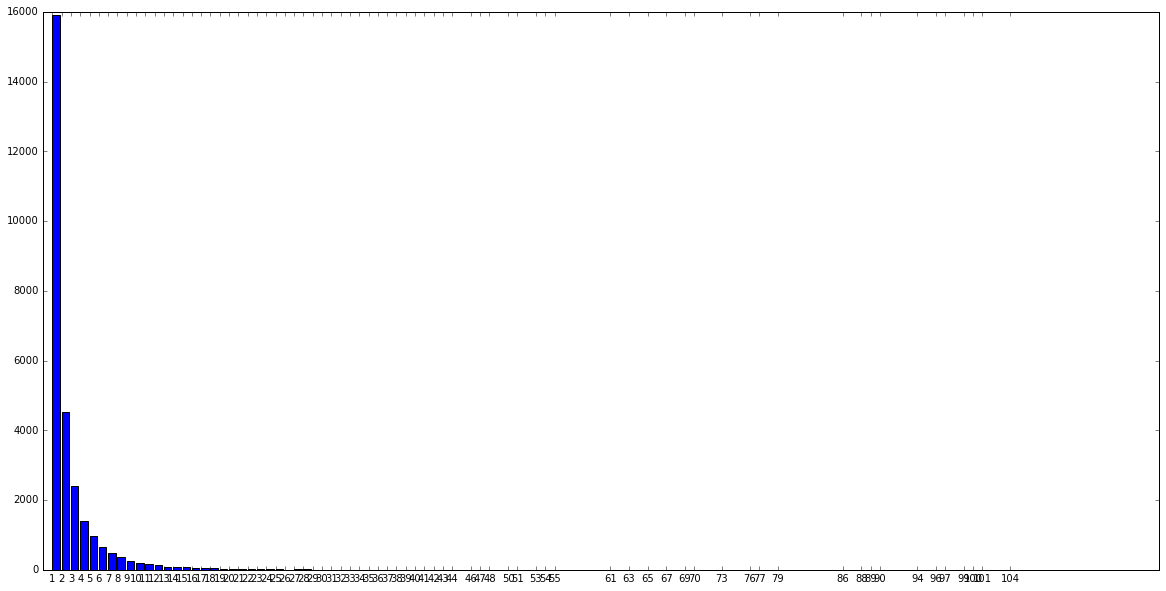

In [186]:
plt.figure(figsize=(20,10))
plt.bar(frequencies.keys(), frequencies.values())
plt.xticks(frequencies.keys())
plt.show()

In [188]:
t_light_curves = threshold_light_curves(light_curves, 2)
lcs = []
for t_light_curve in t_light_curves:
    lcs.append(build_lightcurve(t_light_curve))


In [189]:
frequencies = {}

for lc in lcs:
    if frequencies.has_key(len(lc)):
        frequencies[len(lc)] += 1
    else:
        frequencies[len(lc)] = 1

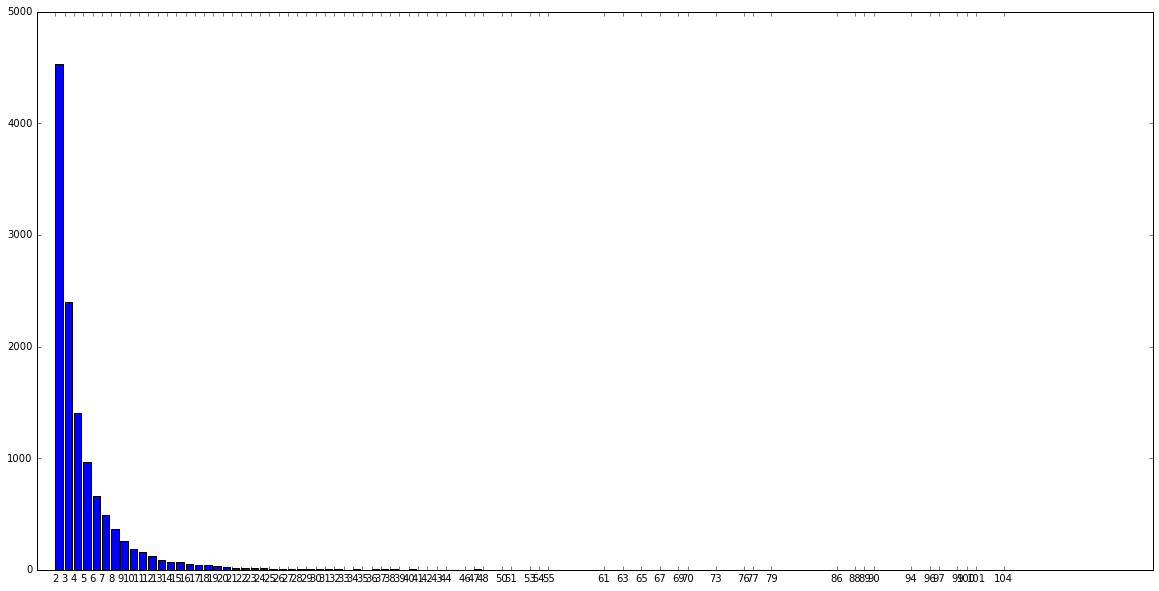

In [190]:
plt.figure(figsize=(20,10))
plt.bar(frequencies.keys(), frequencies.values())
plt.xticks(frequencies.keys())
plt.show()

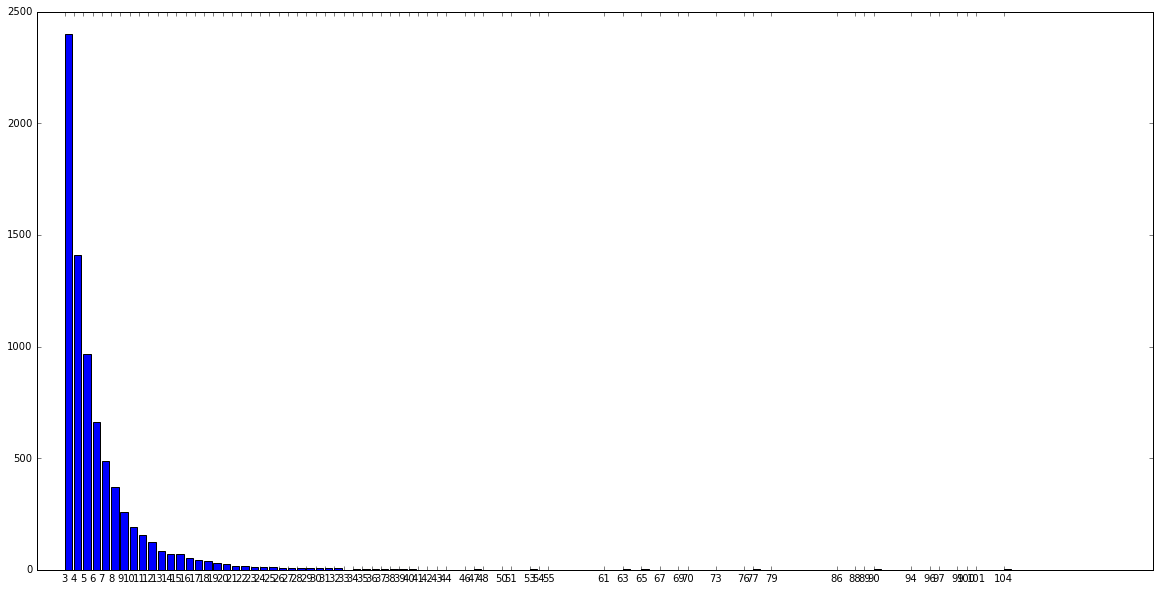

In [191]:
t_light_curves = threshold_light_curves(light_curves, 3)
lcs = []
for t_light_curve in t_light_curves:
    lcs.append(build_lightcurve(t_light_curve))
frequencies = {}

for lc in lcs:
    if frequencies.has_key(len(lc)):
        frequencies[len(lc)] += 1
    else:
        frequencies[len(lc)] = 1
plt.figure(figsize=(20,10))
plt.bar(frequencies.keys(), frequencies.values())
plt.xticks(frequencies.keys())
plt.show()